In [1]:
from emlp.reps import V,sparsify_basis,T
import emlp.groups as groups
import emlp
import jax.numpy as jnp
import numpy as np

In [2]:
%cd ~/programs/avid

/home/nicholas/programs/avid


In [8]:
import matplotlib.pyplot as plt
import rho_plus as rp

rp.mpl_setup(False)


plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.dpi'] = 100

from emlp.reps.linear_operators import LazyPerm
from einops import rearrange
class CubicPerm(emlp.Group):
    def __init__(self, n: int, shift_subgroup: int = 1):
        # space group 195, generators are translations + three rotations
        assert n % shift_subgroup == 0

        base = jnp.arange(n * n * n).reshape(n, n, n)

        rots = []
        taus = []
        for ax in range(3):
            rots.append(jnp.flip(base, ax))
            taus.append(jnp.roll(base, shift_subgroup, axis=ax))

        perms = rearrange(jnp.array([rots + taus]), '1 b nx ny nz -> b (nx ny nz)')
        self.discrete_generators = [LazyPerm(perm) for perm in perms]
        super().__init__(n)


In [26]:
import jax


Cu = CubicPerm(7)

B = (V(Cu) >> V(Cu)).equivariant_basis()

# jnp.save('precomputed/equiv_basis_24.npy', np.array(B))

In [21]:
B.shape

(117649, 64)

In [22]:
7 ** 6

117649

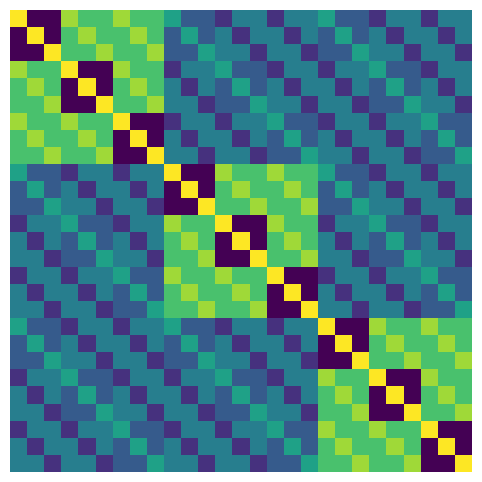

In [35]:
C = CubicPerm(3)


rep = V(C)
emlp.vis(rep, T(1)(C))

plt.gca().set_frame_on(False)